In [10]:
import random 
import torch
import sys
sys.path.append('../') 
import utils as d2l

In [11]:
tokens = d2l.tokenize(d2l.read_time_machine())  
# 因为每个文本行不一定是一个句子或一个段落,因此我们把所有文本行拼接到一起  
corpus = [token for line in tokens for token in line]  
vocab = d2l.Vocab(corpus)  
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

1. 词频图

In [12]:
freqs = [freq for token, freq in vocab.token_freqs] 
len(freqs)

4579

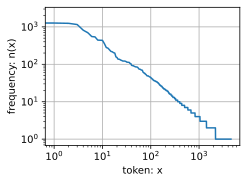

In [13]:
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',  xscale='log', yscale='log')

将前几个单词作为例外消除后,剩余的所有单词大致遵循双对数坐标图上的一条直线。

2. 二元语法

In [14]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]  
bigram_vocab = d2l.Vocab(bigram_tokens)  
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

3. 三元语法

In [15]:
trigram_tokens = [triple for triple in zip(  corpus[:-2], corpus[1:-1], corpus[2:])] 
trigram_vocab = d2l.Vocab(trigram_tokens)  
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

4. 直观地对比三种模型中的词元频率:一元语法、二元语法和三元语法。

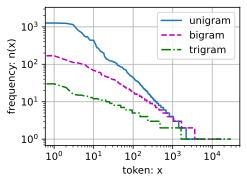

In [16]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]  
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]  
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',  ylabel='frequency: n(x)', 
         xscale='log', yscale='log',  legend=['unigram', 'bigram', 'trigram'])

5. 随机采样：相邻的batch_size的子序列在原始序列 不相邻

In [18]:
my_seq = list(range(35))
for X, Y in d2l.seq_data_iter_random(my_seq, batch_size=3, num_steps=5):  #批量大小为2,时间步数为5
    print('X: ', X, '\nY:', Y)

X:  tensor([[22, 23, 24, 25, 26],
        [ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]])


6. 顺序分区：两个相邻的小批量中的子序列在原始序列上也是相邻的。注意：但是在一个batch_size内的子序列在原始序列中不一定相邻

In [19]:
for X, Y in d2l.seq_data_iter_sequential(my_seq, batch_size=3, num_steps=5):  
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [12, 13, 14, 15, 16],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [13, 14, 15, 16, 17],
        [24, 25, 26, 27, 28]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [17, 18, 19, 20, 21],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [18, 19, 20, 21, 22],
        [29, 30, 31, 32, 33]])


load_data_time_machine
return：数据迭代器和词表

In [20]:
class SeqDataLoader: #@save 
    """加载序列数据的迭代器"""  
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):  
        if use_random_iter:  
            self.data_iter_fn = d2l.seq_data_iter_random 
        else:  
            self.data_iter_fn = d2l.seq_data_iter_sequential  
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)  
        self.batch_size, self.num_steps = batch_size, num_steps  
    def __iter__(self):  
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [21]:
def load_data_time_machine(batch_size, num_steps, #@save  
                           use_random_iter=False, max_tokens=10000): 
    """返回时光机器数据集的迭代器和词表"""  
    data_iter = SeqDataLoader(  
        batch_size, num_steps, use_random_iter, max_tokens) 
    return data_iter, data_iter.vocab

- batch_size:在一个batch内，子序列的个数
- num_steps:time step
- use_random_iter
return :
- data_iter:SeqDataLoader类，访问__iter__属性可以访问每个batch对应的features和label
- data_iter_iter.vocab:整个时光机器数据集的字符频率词表

In [22]:
data_iter,label=load_data_time_machine(2, 5, use_random_iter=False, max_tokens=10000)
print(list(label.token_to_idx.items())[:30])
for X, Y in data_iter. __iter__():  
    print('features: ', X, '\nlabels:', Y)

[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]
features:  tensor([[ 3,  5, 13,  2,  1],
        [14, 11,  2,  1, 17]]) 
labels: tensor([[ 5, 13,  2,  1, 13],
        [11,  2,  1, 17,  4]])
features:  tensor([[13,  4, 15,  9,  5],
        [ 4,  8,  1,  4, 12]]) 
labels: tensor([[ 4, 15,  9,  5,  6],
        [ 8,  1,  4, 12,  7]])
features:  tensor([[ 6,  2,  1, 21, 19],
        [ 7,  6, 18,  3,  9]]) 
labels: tensor([[ 2,  1, 21, 19,  1],
        [ 6, 18,  3,  9,  2]])
features:  tensor([[ 1,  9,  1, 18,  1],
        [ 2,  1,  3,  5, 13]]) 
labels: tensor([[ 9,  1, 18,  1, 17],
        [ 1,  3,  5, 13,  2]])
features:  tensor([[17,  2, 12, 12,  8],
        [ 2,  1, 11,  5, 13]]) 
labels: tensor([[ 2, 12, 12,  8,  5],
        [ 1, 11,  